In [1]:
import os
import sys

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
import ast
import numpy as np

from utils.gcloud_utilities import *
from utils.metadata import *
from utils.preprocessing_utilities import (
    import_operating_nodes,
    expand_parameters_col_and_format,
)

In [3]:
year = "2023"

# Load data
bucket, nodes = import_operating_nodes(year)
endUse_nodes = pull_from_gcs_csv(
    bucket, GCLOUD_PREPROCESSED_DIR + BENCHMARK_PREPROCESSED_DIR + "endUse_nodes.csv"
)

edges = pull_from_gcs_csv(
    bucket,
    GCLOUD_PREPROCESSED_DIR
    + BENCHMARK_PREPROCESSED_DIR
    + BENCHMARK_EDGES_DIR
    + BENCHMARK_EDGES_FILE,
)

edges["properties"] = edges["properties"].astype(str).apply(ast.literal_eval)
dict_df = pd.json_normalize(edges["properties"])
edges = edges.drop(columns=["properties"]).join(dict_df)

nodes_df = pd.concat((nodes, endUse_nodes))

nodes_df["type"] = (
    nodes_df["mine_type"]
    .fillna(nodes_df["process_type"])
    .fillna(nodes_df["product_type"])
)
# nodes_df = nodes_df.dropna(subset=['type'])[['node_id', 'type', year]]

stages_dict = {
    "mining": ["Brine", "Spodumene", "Mica", "Pegmatite"],
    "carbonate": ["Lithium Carbonate"],
    "hydroxide": ["Lithium Hydroxide"],
    "cathode": [
        "NCM mid nickel",
        "LFP",
        "4V Ni or Mn based",
        "NCA",
        "NCM high nickel",
        "LCO",
        "NCM low nickel",
        "5V Mn based",
    ],
    "battery": [
        "Cylindrical",
        "Pouch",
        "Cylindrical, Pouch",
        "Pouch, Prismatic",
        "Prismatic",
        "Cylindrical, Prismatic",
        "Cylindrical, Pouch, Prismatic",
    ],
    "end_use": ["EV", "ESS", "Portable"],
}

nodes_df["stage"] = nodes_df["type"].map(
    {item: cat for cat, items in stages_dict.items() for item in items}
)

# nodes_df = nodes_df.dropna(subset=['stage'])

2025-05-10 11:33:54.927 | INFO     | utils.gcloud_utilities:fetch_gcs_bucket:16 - Fetching GCS bucket: lithium-datasets in project: critical-minerals'


c:\Users\bapti\OneDrive - University of Cambridge\Documents\critical-minerals\.venv\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
2025-05-10 11:33:58.444 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/benchmark_nodes.csv in bucket lithium-datasets
2025-05-10 11:34:00.067 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/endUse_nodes.csv in bucket lithium-datasets
2025-05-10 11:34:00.253 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/edge_creation/benchmark_combined_edges.csv in buck

In [ ]:
inputs = edges.merge(
    nodes_df[["node_id", "type", "stage", "country", "company", "name"]],
    left_on=["source", "edge_type"],
    right_on=["node_id", "type"],
    how="left",
)

outputs = inputs[
    [
        "stage",
        "type",
        "target",
        "2023_volume",
        "edge_type",
        "edge_destination",
        "country",
        "company",
        "name",
    ]
].merge(
    nodes_df[["node_id", "stage", "type", "country", "company", "name"]],
    left_on="target",
    right_on="node_id",
    how="left",
    suffixes=("_source", "_target"),
)

outputs = outputs[
    (outputs["edge_destination"].isna())
    | (outputs["edge_destination"] == outputs["type_target"])
]

# all_flows = outputs[['stage_source', 'type_source', 'stage_target', 'type_target', '2023_volume', 'edge_type']].groupby(['stage_source', 'type_source', 'stage_target', 'type_target', 'edge_type']).sum().reset_index()

In [ ]:
stages = list(stages_dict.keys())
next_stage_map = {stages[i]: stages[i + 1] for i in range(len(stages) - 1)}

# 2. Keep only rows where stage_target matches next_stage_map[stage_source]
real_flows = pd.concat(
    (
        outputs[outputs["stage_source"].map(next_stage_map) == outputs["stage_target"]],
        outputs[
            (outputs["stage_source"] == "mining")
            & (outputs["stage_target"] == "hydroxide")
        ],
        outputs[
            (outputs["stage_source"] == "carbonate")
            & (outputs["stage_target"] == "cathode")
        ],
    )
)

In [ ]:
country_flows = (
    real_flows[
        [
            "stage_source",
            "type_source",
            "stage_target",
            "edge_type",
            "country_source",
            "country_target",
            "2023_volume",
        ]
    ]
    .groupby(
        [
            "stage_source",
            "type_source",
            "stage_target",
            "edge_type",
            "country_source",
            "country_target",
        ]
    )
    .sum()
    .reset_index()
)


country_flows_filt = country_flows[
    [
        i in ["Lithium Carbonate", "Lithium Hydroxide"]
        for i in country_flows["type_source"]
    ]
][["country_source", "country_target", "type_source", "stage_target", "2023_volume"]]


# country_flows_filt = country_flows_filt[country_flows_filt['stage_target'] != 'battery']


country_flows_filt = country_flows_filt[country_flows_filt["2023_volume"] > 1]

In [ ]:
baci_country_codes = pull_from_gcs_csv(
    bucket, BACIDATA_DIR + "country_codes_V202501.csv"
)


hs_codes = {"Lithium Carbonate": 283691, "Lithium Hydroxide": 282520}

baci_data = pull_from_gcs_csv(bucket, BACIDATA_DIR + "BACI_HS22_Y2023_V202501.csv")

baci_filt = baci_data[baci_data["t"] == int(year)]

baci_filt = baci_filt[baci_filt["k"].isin(hs_codes.values())]

baci_filt = baci_filt.merge(
    baci_country_codes[["country_code", "country_iso3"]],
    left_on="i",
    right_on="country_code",
).rename(columns={"country_iso3": "country_source"})

baci_filt = baci_filt.merge(
    baci_country_codes[["country_code", "country_iso3"]],
    left_on="j",
    right_on="country_code",
).rename(columns={"country_iso3": "country_target"})


baci_filt["k"] = baci_filt["k"].map({v: k for k, v in hs_codes.items()})


baci_filt = baci_filt[["country_source", "country_target", "k", "v", "q"]]


unmatched_baci = country_flows_filt.merge(
    baci_filt,
    left_on=["country_source", "country_target", "type_source"],
    right_on=["country_source", "country_target", "k"],
    how="outer",
)

unmatched_baci = unmatched_baci[unmatched_baci["type_source"].isna()]

2025-05-10 11:38:04.336 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from raw/baci/country_codes_V202501.csv in bucket lithium-datasets
2025-05-10 11:38:04.525 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from raw/baci/BACI_HS22_Y2023_V202501.csv in bucket lithium-datasets


In [ ]:
direct_comparison = country_flows_filt.merge(
    baci_filt,
    left_on=["country_source", "country_target", "type_source"],
    right_on=["country_source", "country_target", "k"],
    how="left",
)


direct_comparison["flow_type"] = np.where(
    direct_comparison["country_source"] == direct_comparison["country_target"], 0, 1
)

In [13]:
# Carb overall comparison
carbs = direct_comparison[
    direct_comparison["type_source"] == "Lithium Carbonate"
].dropna(subset=["q"])
carbs["difference"] = abs(carbs["2023_volume"] - carbs["q"]) / carbs["2023_volume"]
carbs["2023_volume"].sum() / carbs["q"].sum()

np.float64(1.1721845448863721)

In [14]:
# Hydrox overall comparison
hydrox = direct_comparison[
    direct_comparison["type_source"] == "Lithium Hydroxide"
].dropna(subset=["q"])
hydrox["difference"] = abs(hydrox["2023_volume"] - hydrox["q"]) / hydrox["2023_volume"]
hydrox["difference"].median()
hydrox["2023_volume"].sum() / hydrox["q"].sum()

np.float64(0.44280168563166894)

In [15]:
# Internal vs external
internal = direct_comparison[
    direct_comparison["country_source"] == direct_comparison["country_target"]
]
external = direct_comparison[
    direct_comparison["country_source"] != direct_comparison["country_target"]
]

internal.groupby("type_source").sum()["2023_volume"] / direct_comparison.groupby(
    "type_source"
).sum()["2023_volume"]

type_source
Lithium Carbonate    0.568594
Lithium Hydroxide    0.700089
Name: 2023_volume, dtype: float64

In [16]:
external.groupby("type_source").sum()["2023_volume"]

type_source
Lithium Carbonate    262706.293690
Lithium Hydroxide     71696.279883
Name: 2023_volume, dtype: float64

In [17]:
direct_comparison.groupby("type_source").sum()["2023_volume"]

type_source
Lithium Carbonate    608953.593283
Lithium Hydroxide    239058.665584
Name: 2023_volume, dtype: float64

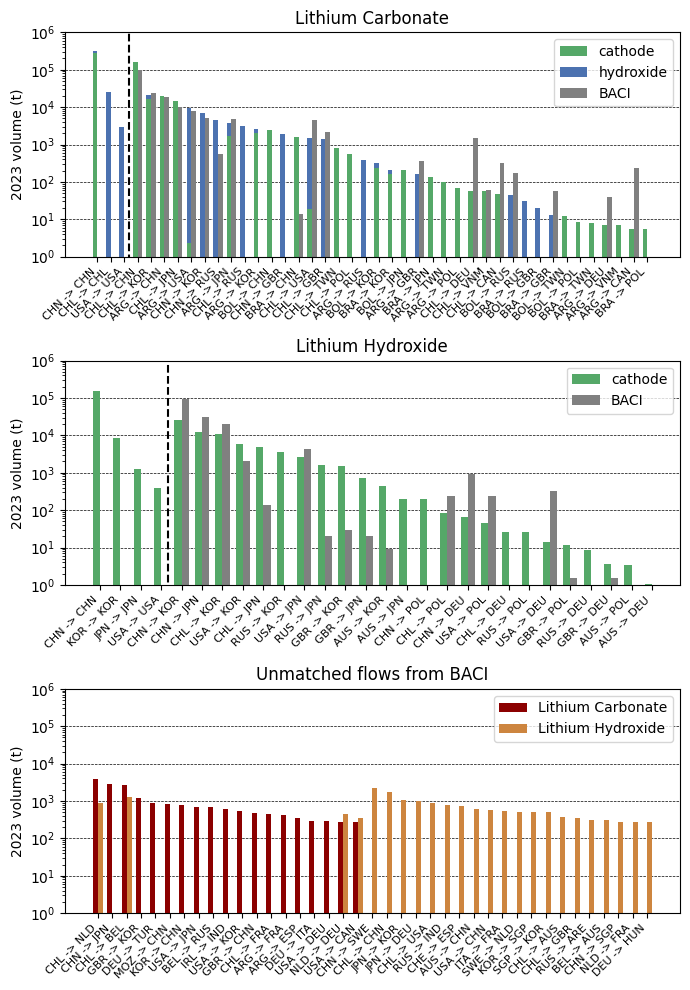

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = direct_comparison.copy()

df["label"] = df["country_source"] + " -> " + df["country_target"]

# --- Set up the figure with two subplots (one above the other) ---
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10), sharex=False)

# Define a color mapping for stage_target
colors = {"hydroxide": "#4C72B0", "cathode": "#55A868"}


def plot_subplot(ax, df_sub, title):
    """
    For a given type_source, this function:
      - Pivots the data so that for each label the contributions to 2023_volume (vol)
        are split by stage_target.
      - Sorts the x ticks by total 2023_volume (highest left).
      - Plots two bars at each x tick: a stacked bar for 2023_volume and a single bar for q.
    """
    # Pivot the data so each label shows separate columns for stage_target
    pivot_vol = df_sub.pivot_table(
        index="label", columns="stage_target", values="2023_volume", aggfunc="sum"
    )
    pivot_vol = pivot_vol.fillna(0)  # Fill missing stage_target values with 0.
    # Retrieve the q values (they are assumed identical for the same label)
    q_vals = df_sub.groupby("label")["q"].first()

    # Create an aggregated DataFrame with total volume and flow_type (assumed constant per label)
    agg = df_sub.groupby("label").agg(
        total_vol=("2023_volume", "sum"), flow_type=("flow_type", "first")
    )
    # Sort first by flow_type ascending, then by total volume descending
    sorted_idx = agg.sort_values(
        by=["flow_type", "total_vol"], ascending=[True, False]
    ).index

    pivot_vol = pivot_vol.loc[sorted_idx]
    q_vals = q_vals.loc[sorted_idx]

    x = np.arange(len(sorted_idx))
    bar_width = 0.35

    # Plot the 2023_volume as a stacked bar (positioned to the left of each tick)
    bottoms = np.zeros(len(sorted_idx))
    for stage in pivot_vol.columns:
        ax.bar(
            x - bar_width / 2,
            pivot_vol[stage].values,
            bar_width,
            bottom=bottoms,
            label=stage,
            color=colors.get(stage),
        )
        bottoms += pivot_vol[stage].values

    # Plot the q values as a separate bar (positioned to the right of each tick)
    ax.bar(x + bar_width / 2, q_vals.values, bar_width, label="BACI", color="grey")

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_idx, rotation=45, ha="right")
    ax.set_ylabel(year + " volume (t)")
    ax.set_yscale("log")
    ax.set_ylim(1, 1e6)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, color="black")
    ax.tick_params(axis="x", labelsize=8)
    # Optionally include a legend; if you want one legend for the whole figure, adjust accordingly
    ax.legend(loc="upper right")


# --- Plot for Lithium Hydroxide (top subplot) ---
df_hydroxide = df[df["type_source"] == "Lithium Hydroxide"]
plot_subplot(axes[1], df_hydroxide, "Lithium Hydroxide")
axes[1].vlines(x=3.33, ymin=0, ymax=1000000, color="k", linestyle="--")

# --- Plot for Lithium Carbonate (bottom subplot) ---
df_carbonate = df[df["type_source"] == "Lithium Carbonate"]
plot_subplot(axes[0], df_carbonate, "Lithium Carbonate")
axes[0].vlines(x=2.33, ymin=0, ymax=1000000, color="k", linestyle="--")

# -----------------------
# Plot the third subplot using a different dataframe (df_q)
# -----------------------


ub = unmatched_baci.sort_values("q", ascending=False)
ub["label"] = ub["country_source"] + " -> " + ub["country_target"]
ub = ub[ub["q"] > 250]
# ub['type_source'] = ub['k']
# ub[year+'_volume'] = 0
# ub['stage_target'] = 'cathode'

# Pivot the data so that each label has separate columns for k
pivot_q = ub.pivot(index="label", columns="k", values="q")
# Sort by the q value for Lithium Carbonate (highest first)
pivot_q = pivot_q.sort_values(
    by=["Lithium Carbonate", "Lithium Hydroxide"], ascending=False
)

x = np.arange(len(pivot_q))
bar_width = 0.35

# Use different colors for the third subplot
color_carbonate = "#8B0000"  # Matte red: a deep, muted red
color_hydroxide = "#CD853F"  # Matte orange: a soft, understated orange

axes[2].bar(
    x - bar_width / 2,
    pivot_q["Lithium Carbonate"],
    bar_width,
    label="Lithium Carbonate",
    color=color_carbonate,
)
axes[2].bar(
    x + bar_width / 2,
    pivot_q["Lithium Hydroxide"],
    bar_width,
    label="Lithium Hydroxide",
    color=color_hydroxide,
)

axes[2].set_xticks(x)
axes[2].set_xticklabels(pivot_q.index, rotation=45, ha="right")
axes[2].set_ylabel(year + " volume (t)")
axes[2].set_yscale("log")
axes[2].set_ylim(1, 1e6)
axes[2].set_axisbelow(True)
axes[2].yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, color="black")
axes[2].tick_params(axis="x", labelsize=8)
axes[2].set_title("Unmatched flows from BACI")
axes[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [23]:
project_root

'c:\\Users\\bapti\\OneDrive - University of Cambridge\\Documents\\critical-minerals'

In [26]:
# Save output plot
output_path = "/figures/article_figures/"
fig.savefig(
    project_root + output_path + "result_baci_validation.png",
    bbox_inches="tight",
    dpi=300,
)
fig.savefig(
    project_root + output_path + "result_baci_validation.eps",
    format="eps",
    bbox_inches="tight",
    dpi=300,
)
fig.savefig(
    project_root + output_path + "result_baci_validation.pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=300,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [27]:
# Aus-CHN comparison
aus_chn = real_flows[
    (real_flows["stage_source"] == "mining")
    & (real_flows["country_source"] == "AUS")
    & (real_flows["country_target"] == "CHN")
]

aus_chn["name_target"] = aus_chn["name_target"].str.split(" ").str[0]

# aus_chn['name_source'].unique()
#
# len(aus_chn['name_target'].unique())
#
# aus_chn[['name_source', 'name_target', '2023_volume']].groupby(['name_source', 'name_target']).sum().sort_values(['name_source', 'name_target'], ascending=True)
#
# # Greenbushes to Suining
# 6793.513379/4589
#
# # Cattlin to Ya'an
# 1832.037757/4043
#
# # Marion to Xinyu
# 2878.678365/2963

C:\Users\bapti\AppData\Local\Temp\ipykernel_47288\3397945219.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus_chn['name_target'] = aus_chn['name_target'].str.split(' ').str[0]
